In [1]:
library(tidyverse)
library(cowplot)
library(ggrepel)
library(ggbeeswarm)

`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



## Calibration curves

In [2]:
cal <- read_csv('hetionet_calibration_bins.csv')

cal %>% head

Parsed with column specification:
cols(
  expected_frac = col_double(),
  lower_ci = col_double(),
  upper_ci = col_double(),
  feature = col_character(),
  feature_value = col_double(),
  metaedge = col_character()
)


expected_frac,lower_ci,upper_ci,feature,feature_value,metaedge
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
4.288948e-05,3.844812e-05,4.757006e-05,xswap_prior,7.924889e-05,AdG
3.328834e-02,3.208904e-02,3.450858e-02,xswap_prior,3.966895e-02,AdG
6.791022e-02,6.621029e-02,6.962982e-02,xswap_prior,7.559303e-02,AdG
1.034399e-01,1.013953e-01,1.055023e-01,xswap_prior,1.201175e-01,AdG
1.846496e-01,1.820304e-01,1.872830e-01,xswap_prior,1.817673e-01,AdG
3.195830e-01,3.164370e-01,3.227372e-01,xswap_prior,2.787142e-01,AdG


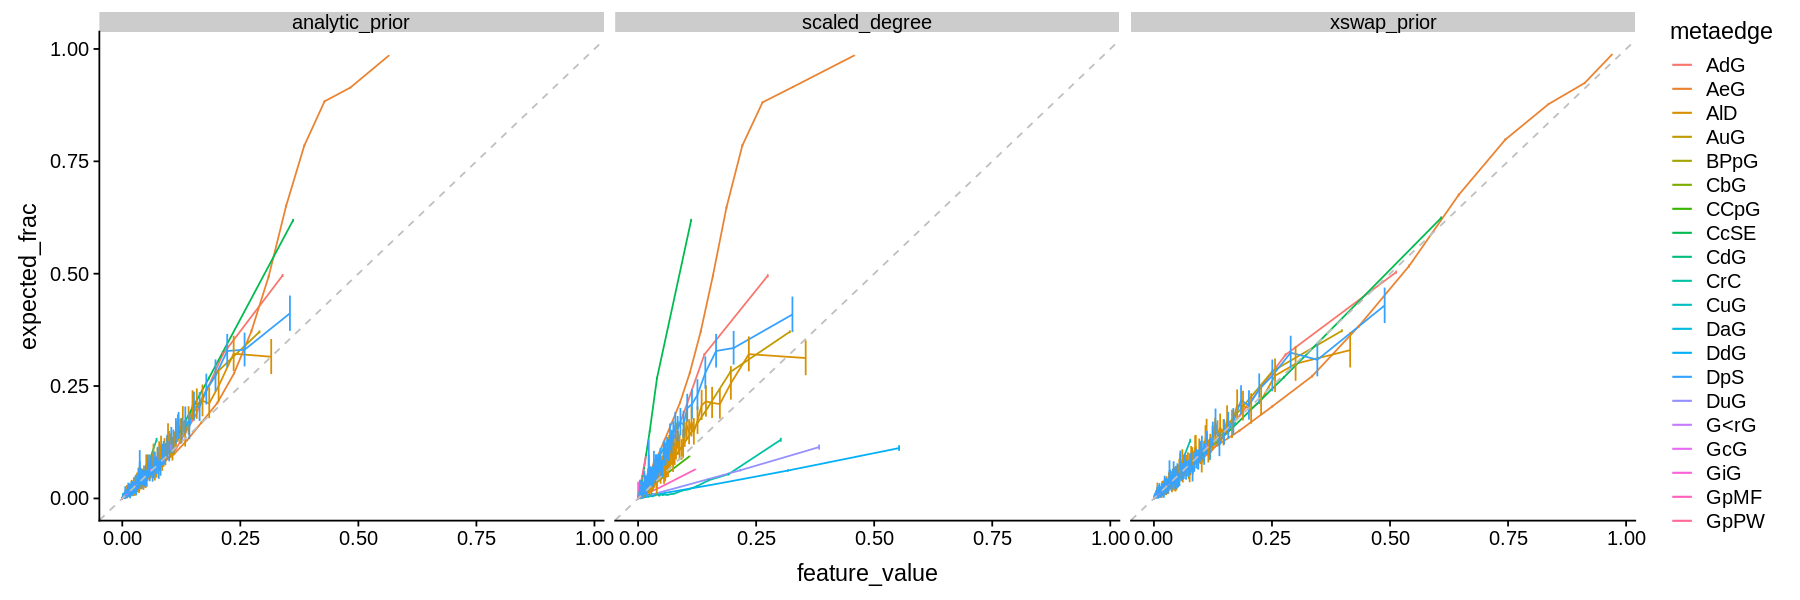

In [3]:
options(repr.plot.width=15, repr.plot.height=5)

calibration_plot <- (
    ggplot(cal, aes(x = feature_value, y = expected_frac, ymin = lower_ci, 
                    ymax = upper_ci, color = metaedge))
    + geom_line()
    + geom_errorbar()
    + geom_abline(color = 'grey', linetype = 'dashed')
    + facet_wrap(vars(feature))
)

calibration_plot

## Calibration metrics

In [4]:
metrics <- read_csv('hetionet_calibration_metrics.csv')

metrics %>% head

Parsed with column specification:
cols(
  network = col_character(),
  metaedge = col_character(),
  feature = col_character(),
  cal = col_double(),
  ref = col_double(),
  brier = col_double(),
  auroc = col_double()
)


network,metaedge,feature,cal,ref,brier,auroc
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
full,AdG,xswap_prior,0.0005348332,0.007573513,0.008108346,0.9893918
full,AdG,analytic_prior,0.0009179593,0.007571256,0.008489216,0.9891555
full,AdG,scaled_degree,0.0015091243,0.007574097,0.009083222,0.9891437
full,AeG,xswap_prior,0.0011463458,0.018729566,0.019875912,0.9873503
full,AeG,analytic_prior,0.0104608217,0.018719604,0.029180426,0.9868655
full,AeG,scaled_degree,0.0195552381,0.018735534,0.038290772,0.9868530


In [5]:
mean_metrics <- metrics %>%
    group_by(network, feature) %>%
    summarize_at(c('cal', 'ref', 'brier', 'auroc'), mean) %>%
    gather('metric', 'value', cal, ref, brier, auroc) %>%
    ungroup() %>%
    mutate(
        network = network %>% factor(levels = c('full', 'sampled', 'other')),
        feature = feature %>% factor(levels = c('analytic_prior', 'scaled_degree', 'xswap_prior'))
    )

mean_metrics %>% head

network,feature,metric,value
<fct>,<fct>,<chr>,<dbl>
full,analytic_prior,cal,0.0011008141
full,scaled_degree,cal,0.0018726902
full,xswap_prior,cal,0.0003926411
other,analytic_prior,cal,0.0719790204
other,scaled_degree,cal,0.0081796607
other,xswap_prior,cal,0.0074513854


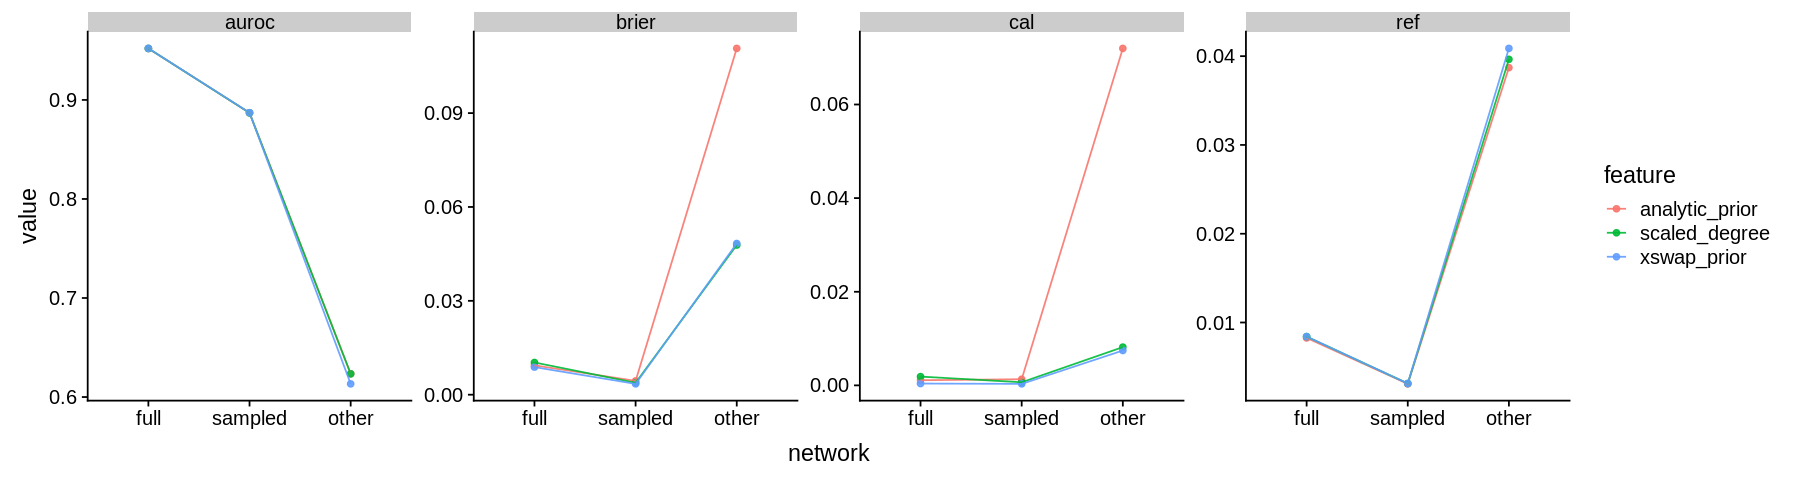

In [6]:
options(repr.plot.width=15, repr.plot.height=4)

(
    ggplot(mean_metrics, aes(x = network, y = value, group = feature, color = feature))
    + geom_point(alpha = 0.9)
    + geom_line(alpha = 0.9)
#     + geom_label_repel(data = mean_metrics %>% filter(network == 'sampled' & metric == 'ref'), 
#                        aes(label = feature), nudge_x = 1, nudge_y = 0.003)
    + facet_wrap(vars(metric), nrow = 1, scales = 'free_y')
)

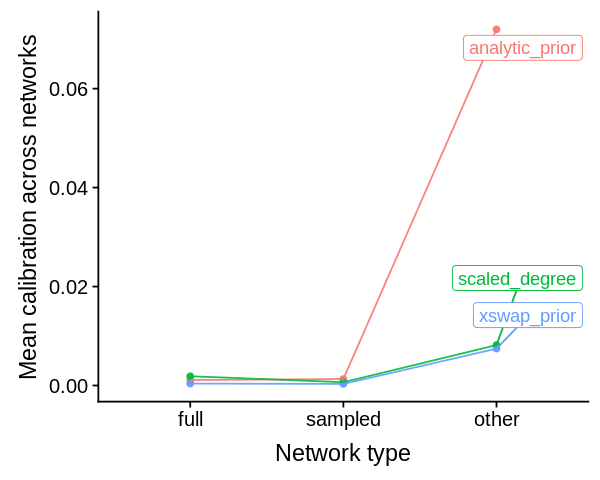

In [7]:
options(repr.plot.width=5, repr.plot.height=4)

mean_cal <- (
    ggplot(mean_metrics %>% filter(metric == 'cal'), 
           aes(x = network, y = value, group = feature, color = feature))
    + geom_point(alpha = 0.9)
    + geom_line(alpha = 0.9)
    + geom_label_repel(data = mean_metrics %>% filter(metric == 'cal' & network == 'other'),
                       aes(label = feature), nudge_x = 5, nudge_y = 0.01)
    + theme(legend.position = "none")
    + ylab('Mean calibration across networks')
    + xlab('Network type')
)

mean_cal

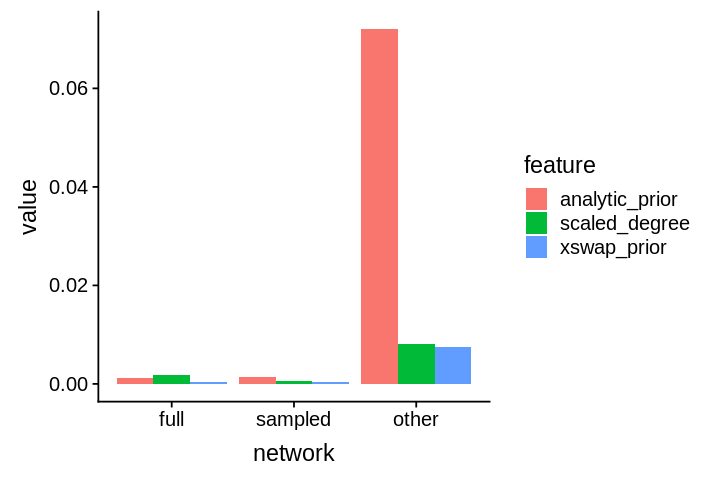

In [8]:
options(repr.plot.width=6, repr.plot.height=4)

(
    ggplot(mean_metrics %>% filter(metric == 'cal'), 
           aes(x = network, y = value, group = feature))
    + geom_col(aes(fill = feature), position = 'dodge')
)

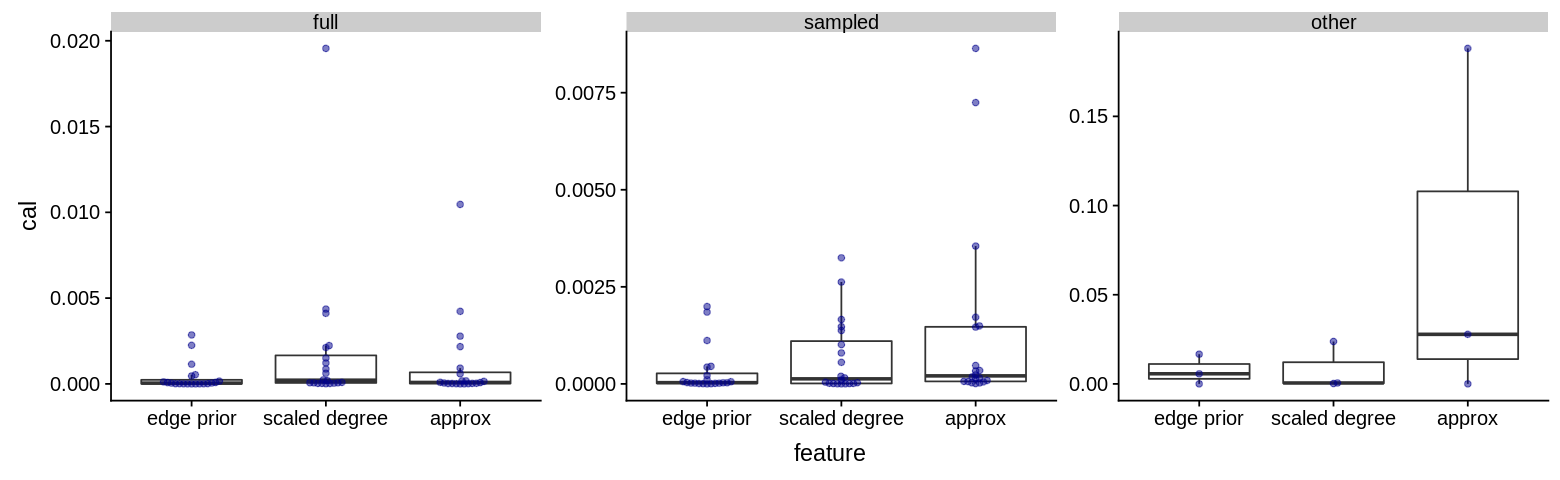

In [9]:
options(repr.plot.width=13, repr.plot.height=4)

all_cal <- (
    ggplot(metrics %>%
               mutate(
                   network = network %>% factor(levels = c('full', 'sampled', 'other')),
                   feature = feature %>% recode_factor(xswap_prior = 'edge prior', 
                                                       scaled_degree = 'scaled degree', 
                                                       analytic_prior = 'approx'),
               ), 
           aes(x = feature, y = cal))
    + facet_wrap(vars(network), scales = 'free_y')
    + geom_boxplot(outlier.shape = NA)
    + geom_beeswarm(alpha = 0.5, color = 'darkblue')
)

all_cal

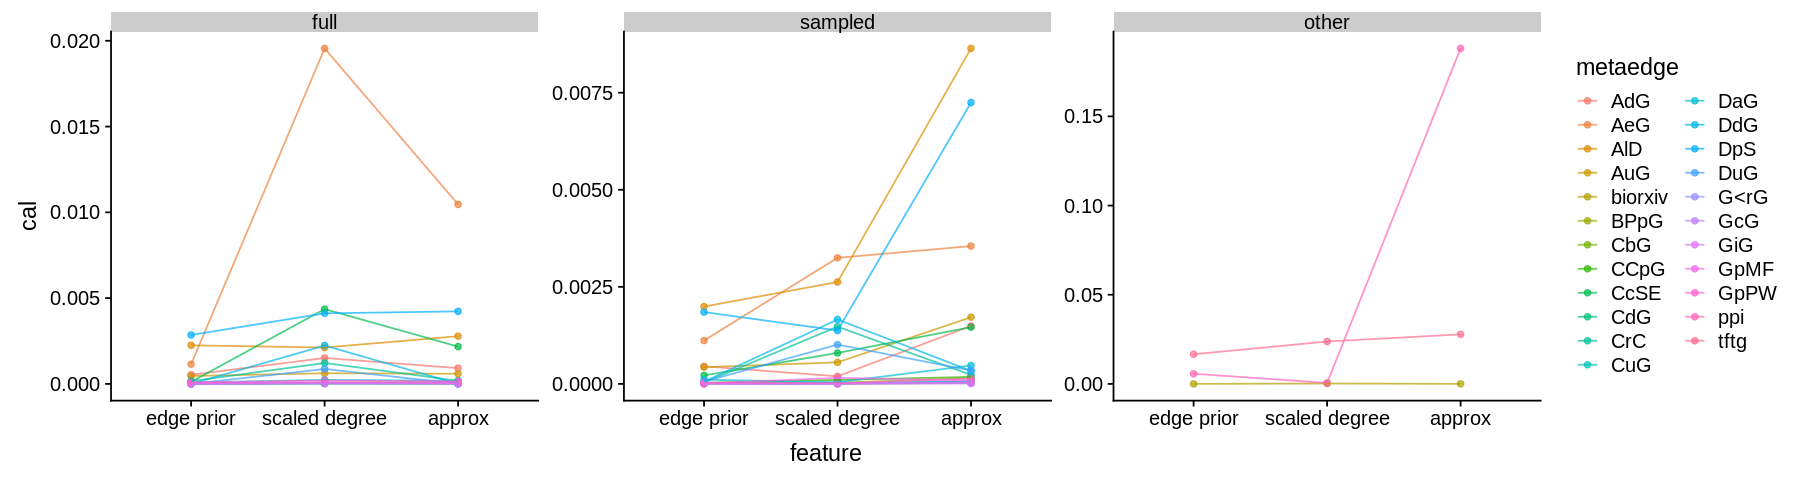

In [10]:
options(repr.plot.width=15, repr.plot.height=4)

(
    ggplot(metrics %>%
               mutate(
                   network = network %>% factor(levels = c('full', 'sampled', 'other')),
                   feature = feature %>% recode_factor(xswap_prior = 'edge prior', 
                                                       scaled_degree = 'scaled degree', 
                                                       analytic_prior = 'approx'),
               ), 
           aes(x = feature, y = cal, group = metaedge, color = metaedge))
    + facet_wrap(vars(network), scales = 'free_y')
#     + geom_boxplot(outlier.shape = NA)
#     + geom_beeswarm(alpha = 0.5, color = 'darkblue')
    + geom_point(alpha = 0.7)
    + geom_line(alpha = 0.7)
)

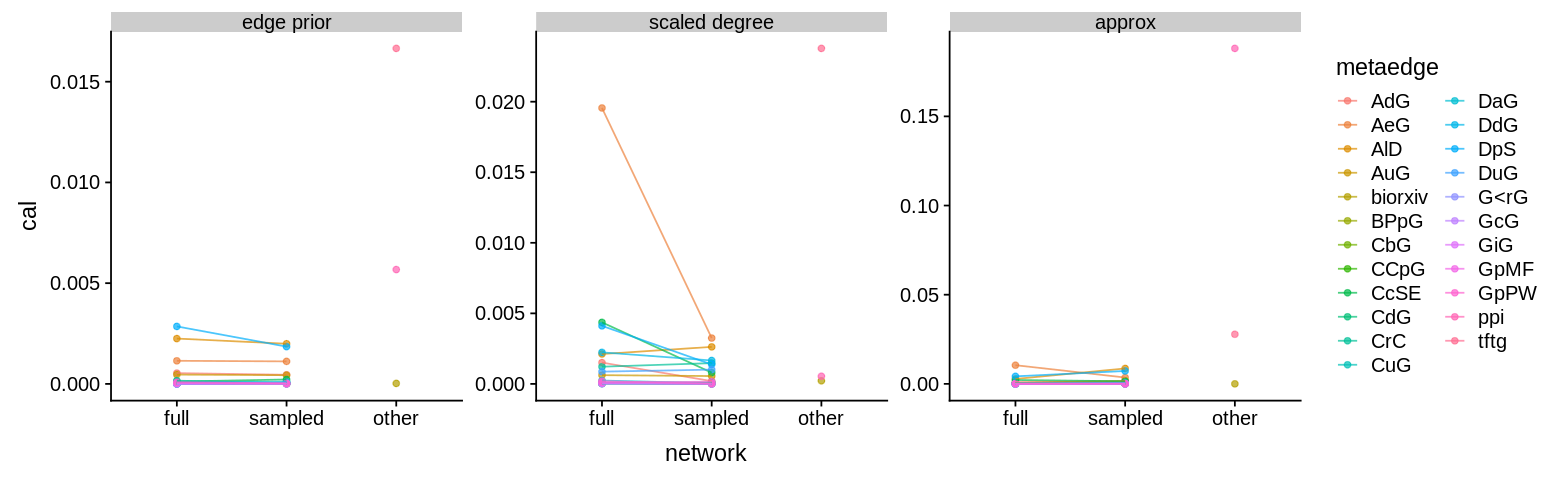

In [11]:
options(repr.plot.width=13, repr.plot.height=4)

(
    ggplot(metrics %>%
               mutate(
                   network = network %>% factor(levels = c('full', 'sampled', 'other')),
                   feature = feature %>% recode_factor(xswap_prior = 'edge prior', 
                                                       scaled_degree = 'scaled degree', 
                                                       analytic_prior = 'approx'),
               ), 
           aes(x = network, y = cal, group = metaedge, color = metaedge))
    + facet_wrap(vars(feature), scales = 'free_y')
#     + geom_boxplot(outlier.shape = NA)
#     + geom_beeswarm(alpha = 0.5, color = 'darkblue')
    + geom_point(alpha = 0.7)
    + geom_line(alpha = 0.7)
)

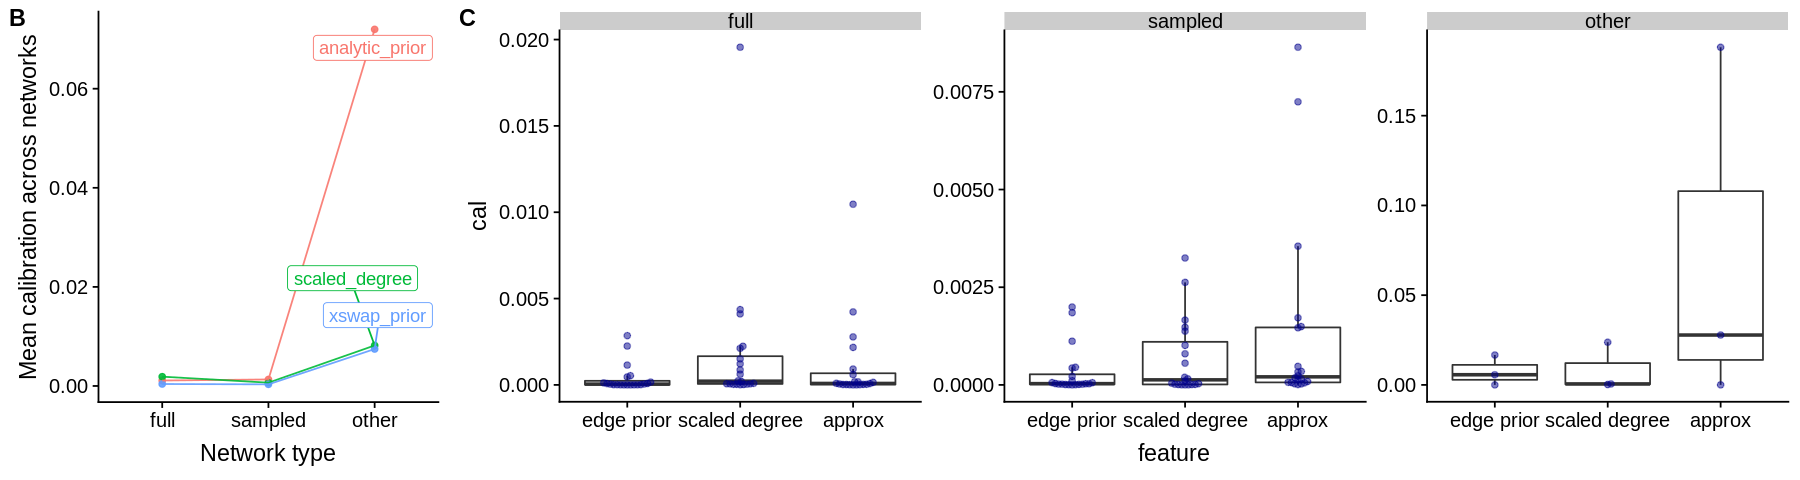

In [12]:
options(repr.plot.width=15, repr.plot.height=4)

second_row <- plot_grid(mean_cal, all_cal, labels = c("B", "C"), nrow = 1, rel_widths = c(0.5, 1.5))

second_row

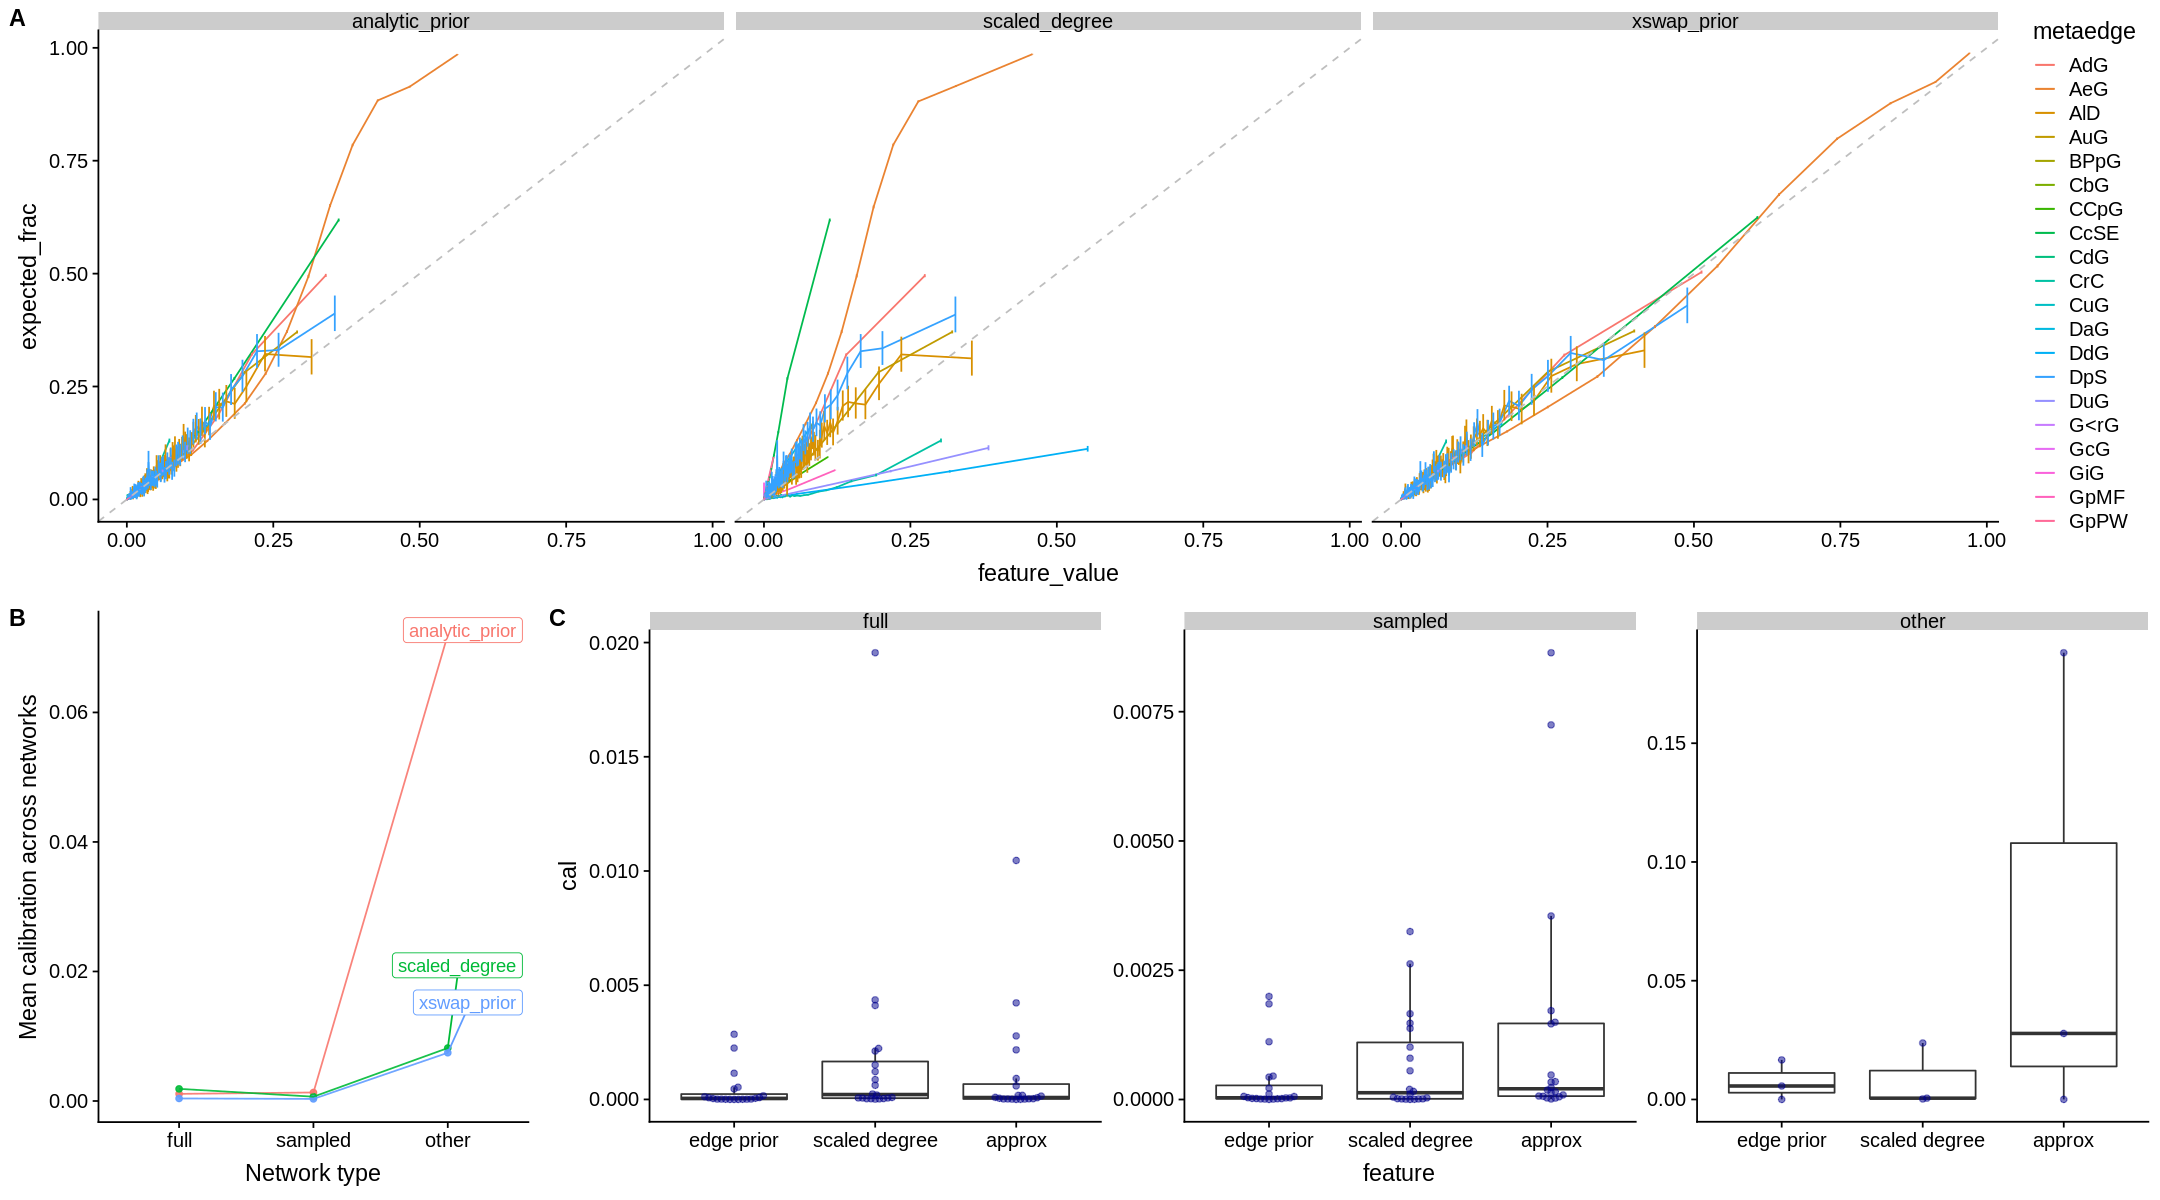

In [13]:
options(repr.plot.width=18, repr.plot.height=10)

full <- plot_grid(calibration_plot, second_row, ncol = 1, labels = c("A", ""))

ggsave(filename = '../../img/calibration_combined.png', plot = full, dpi = 300, width = 18, height = 10)

full

In [31]:
metrics %>%
    filter(network == 'full') %>%
    select(-ref, -brier, -network) %>%
    group_by(metaedge) %>%
    mutate(feature_auroc_rank = rank(desc(auroc))) %>%
    ungroup() %>%
    group_by(feature) %>%
    summarize(mean_auroc_rank = mean(feature_auroc_rank))

feature,mean_auroc_rank
<chr>,<dbl>
analytic_prior,2.00
scaled_degree,2.25
xswap_prior,1.75


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


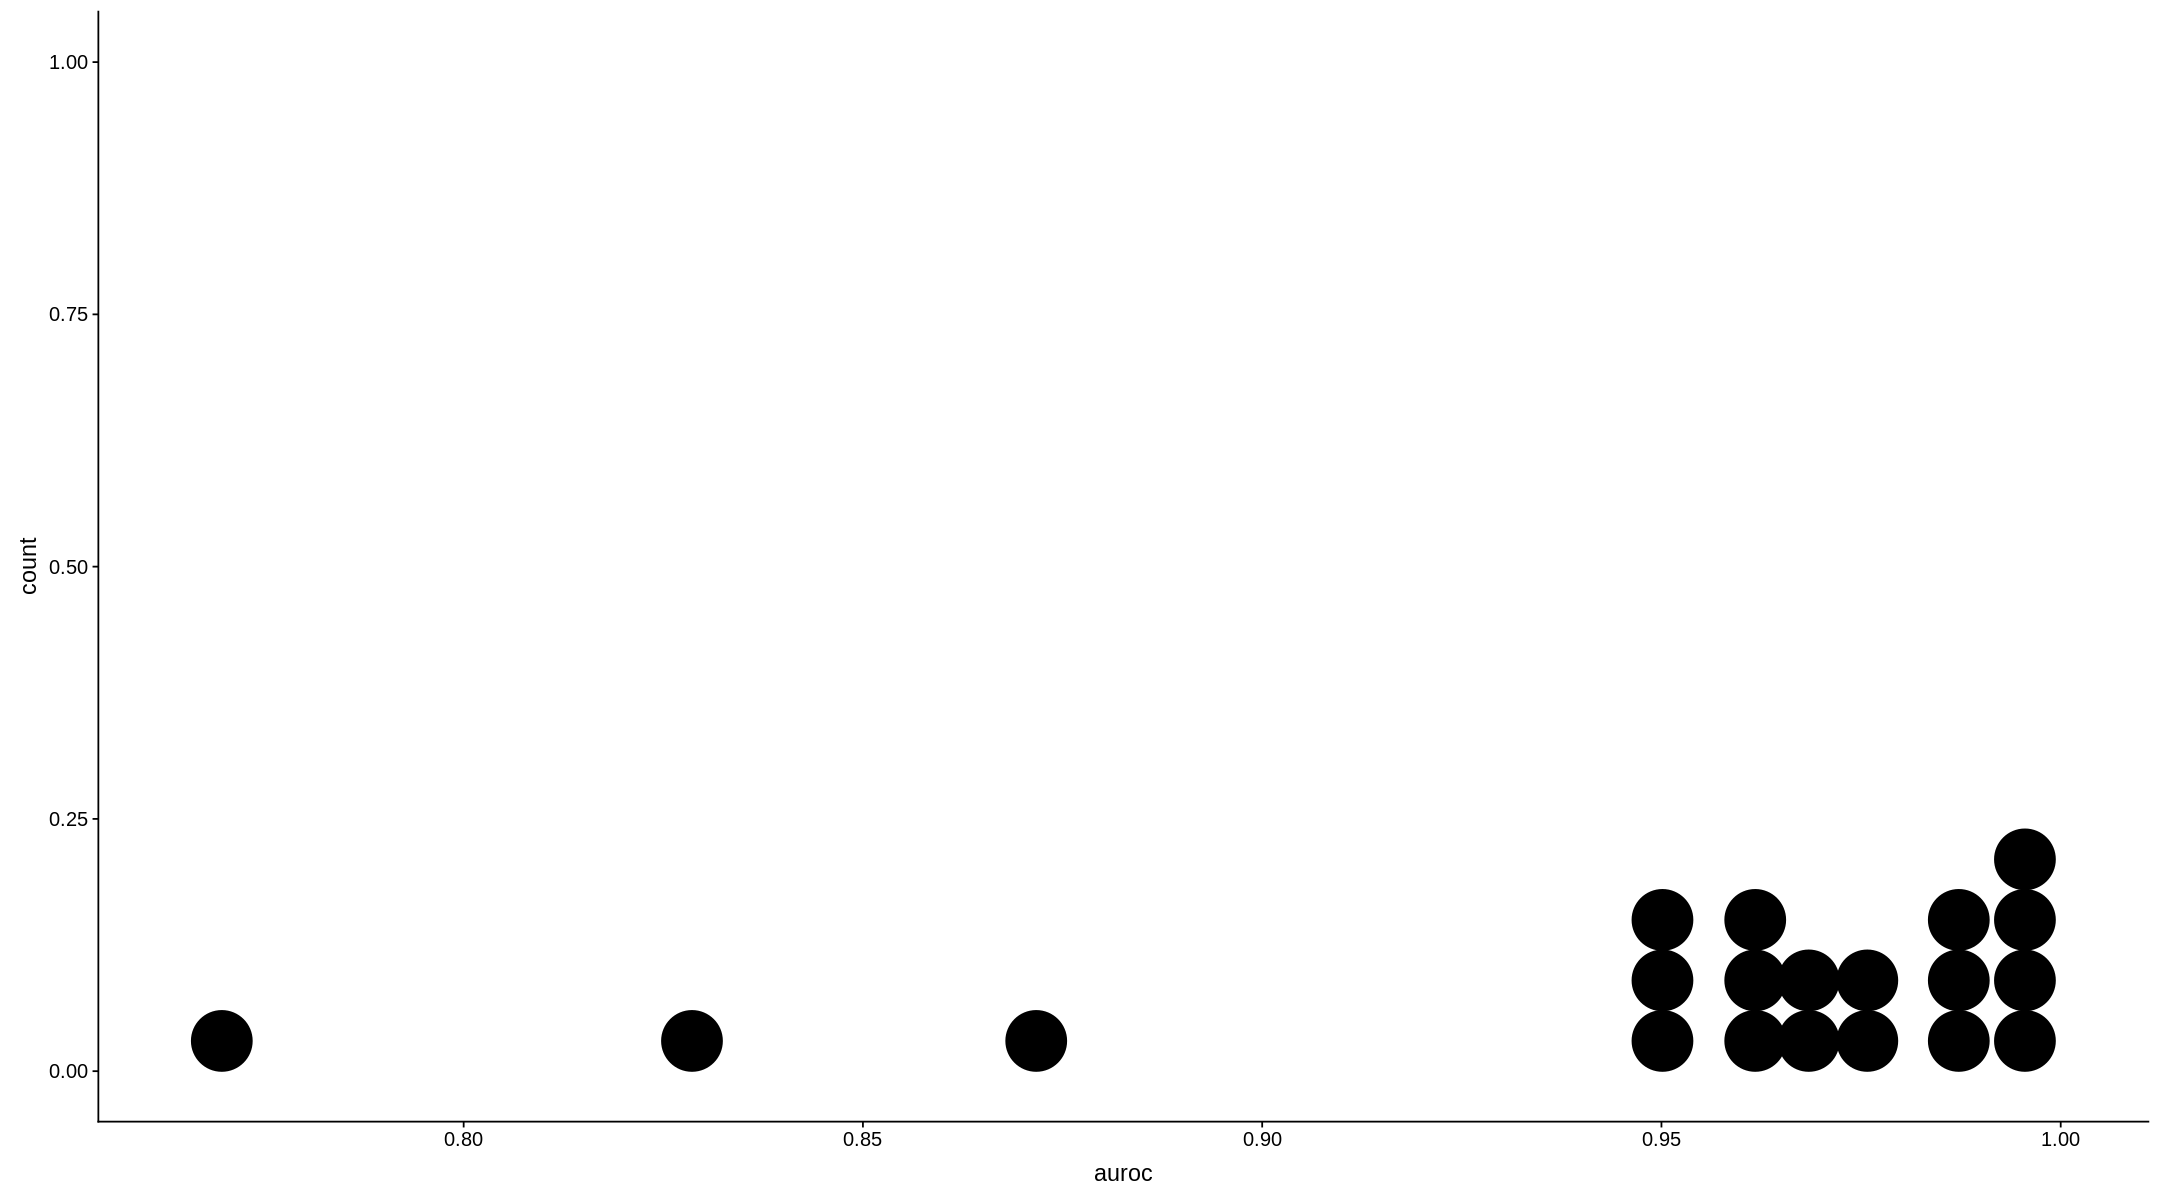

In [34]:
metrics %>%
filter(network == 'full' & feature == 'xswap_prior') %>%
ggplot(aes(x = auroc)) +
geom_dotplot()

In [38]:
network_size <- read_csv('original_work/hetionet_features.csv')

Parsed with column specification:
cols(
  density = col_double(),
  gini = col_double(),
  heterogeneity = col_double(),
  mean_var = col_double(),
  metaedge = col_character(),
  num_source = col_double(),
  num_target = col_double(),
  var = col_double()
)


In [44]:
metrics %>%
filter(network == 'sampled' & feature == 'xswap_prior') %>%
arrange(auroc) %>%
left_join(network_size, by = 'metaedge') %>%
select(metaedge, feature, cal, auroc, density, gini, num_source, num_target)

metaedge,feature,cal,auroc,density,gini,num_source,num_target
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DdG,xswap_prior,5.785075e-05,0.6447831,0.0026565928,0.8879028,137,20945
DuG,xswap_prior,5.988771e-05,0.6538778,0.0026942305,0.8926868,137,20945
AlD,xswap_prior,1.993360e-03,0.7144441,0.0654029124,0.4378844,402,137
DpS,xswap_prior,1.849097e-03,0.7832143,0.0559444056,0.5348740,137,438
DaG,xswap_prior,1.087258e-04,0.7939373,0.0043990779,0.9228070,137,20945
CrC,xswap_prior,3.547152e-05,0.8429015,0.0053889410,0.5839692,1552,1552
GpMF,xswap_prior,1.438064e-05,0.9189549,0.0016094924,0.7602170,20945,2884
GcG,xswap_prior,1.323484e-06,0.9236254,0.0002812579,0.8104507,20945,20945
CCpG,xswap_prior,3.108081e-05,0.9293889,0.0025250481,0.8235690,1391,20945


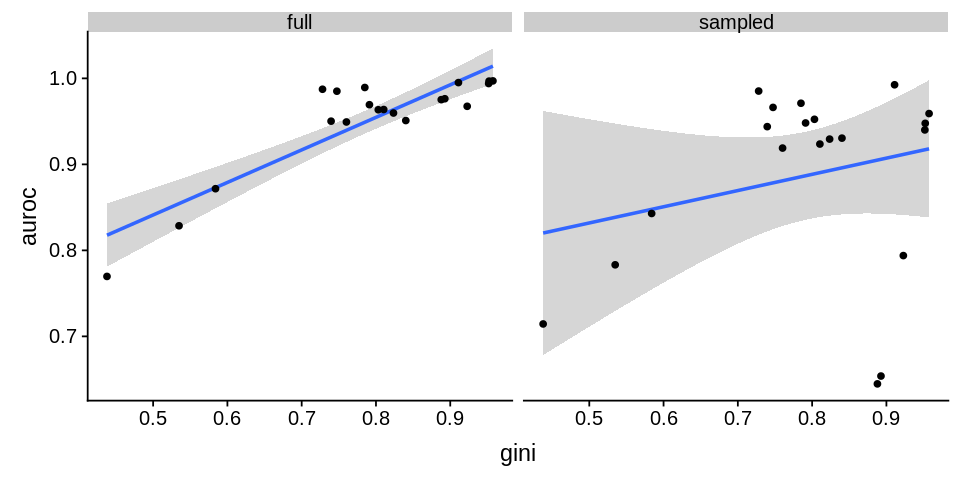

In [67]:
options(repr.plot.width=8, repr.plot.height=4)

metrics %>%
filter(feature == 'xswap_prior' & network != 'other') %>%
left_join(network_size, by = 'metaedge') %>%
ggplot(aes(x = gini, y = auroc)) +
geom_smooth(method = 'lm') +
geom_point() +
facet_wrap(vars(network))

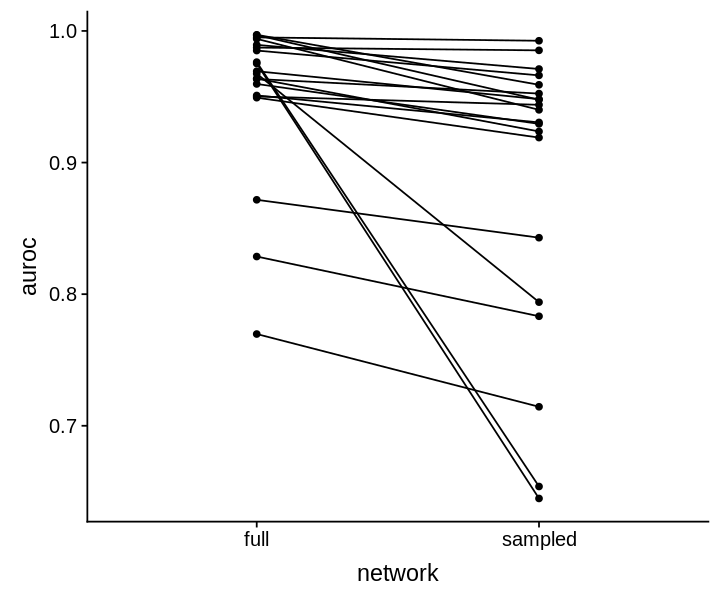

In [51]:
options(repr.plot.width=6, repr.plot.height=5)

metrics %>%
filter(feature == 'xswap_prior', network != 'other') %>%
mutate(network = network %>% factor(levels = c('full', 'sampled'))) %>%
ggplot(aes(x = network, y = auroc, group = metaedge)) +
geom_point() +
geom_line()